# **Loading Preprocessed Data Baseline Performance**


Loading libraries, data, and splitting

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

###############################################################################
# 1) DATA PREPARATION & TRAIN/TEST SPLIT
###############################################################################
df_adjusted = pd.read_csv("Adjusted_Sentiment_Dataset.csv", keep_default_na=False)

# Encode the labels (assuming categorical sentiment labels)
le = LabelEncoder()
df_adjusted['label'] = le.fit_transform(df_adjusted['label'])


df_adjusted.head()

,Statement,Status,label
0,tone social media take inform technolog post s...,Personality disorder,4
1,help mom lean emot come father execut n relati...,Stress,5
2,worri much non disturb sleep,Anxiety,0
3,friend jail think crash im certain blood set f...,Depression,2
4,week long attack name spur three year ago decl...,Anxiety,0


Doing the baseline performance using logistic regression

Label Encoder classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']

[Baseline (Train)] Accuracy: 0.8614
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.89      0.89      0.89      6400
             Bipolar       0.95      0.90      0.93      6400
          Depression       0.75      0.71      0.73      6400
              Normal       0.86      0.94      0.90      6400
Personality disorder       0.93      0.95      0.94      6400
              Stress       0.89      0.86      0.87      6400
            Suicidal       0.76      0.76      0.76      6400

            accuracy                           0.86     44800
           macro avg       0.86      0.86      0.86     44800
        weighted avg       0.86      0.86      0.86     44800



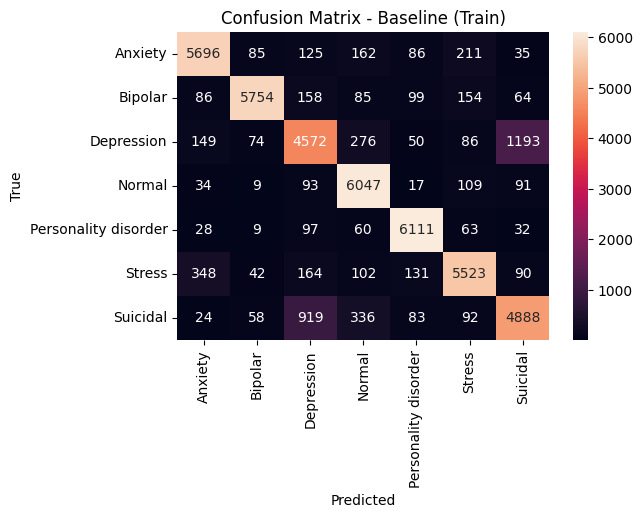


[Baseline (Test)] Accuracy: 0.8102
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.85      0.85      1600
             Bipolar       0.92      0.86      0.89      1600
          Depression       0.66      0.64      0.65      1600
              Normal       0.82      0.92      0.87      1600
Personality disorder       0.89      0.92      0.90      1600
              Stress       0.83      0.79      0.81      1600
            Suicidal       0.70      0.69      0.70      1600

            accuracy                           0.81     11200
           macro avg       0.81      0.81      0.81     11200
        weighted avg       0.81      0.81      0.81     11200



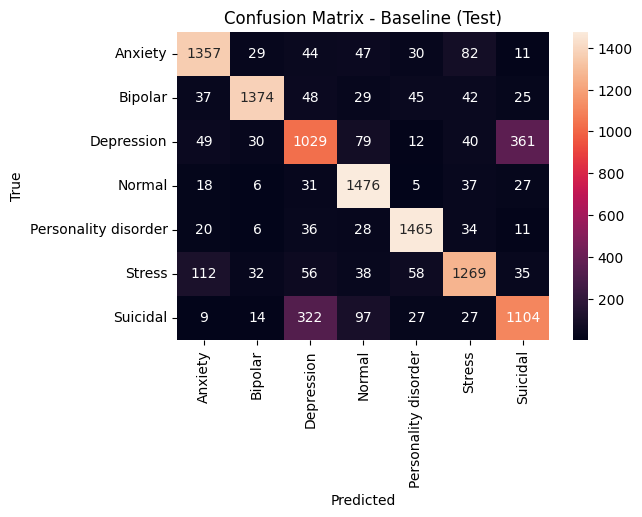

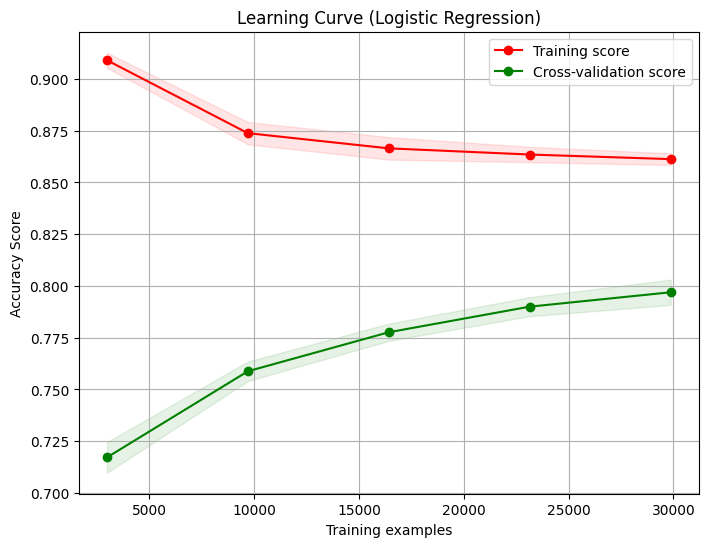

In [ ]:
###############################################################################
# 2) ENCODE THE TEXT LABELS (STATUS) WITH LabelEncoder
###############################################################################
le = LabelEncoder()

# Fit on the 'Status' column (the text labels like Anxiety, Stress, etc.)
df_adjusted['EncodedLabel'] = le.fit_transform(df_adjusted['Status'])

# Store these class names for plotting
class_names = le.classes_
print("Label Encoder classes:", class_names)

###############################################################################
# 3) TRAIN/TEST SPLIT
###############################################################################
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_adjusted['Statement'],
    df_adjusted['EncodedLabel'],  # use the new encoded label column
    test_size=0.2,
    random_state=42,
    stratify=df_adjusted['EncodedLabel']
)

###############################################################################
# 4) TF-IDF VECTORIZATION
###############################################################################
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

###############################################################################
# 5) HELPER FUNCTION TO EVALUATE MODEL
###############################################################################
def evaluate_model(model, X_test, y_test, approach_name):
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n[{approach_name}] Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f"Confusion Matrix - {approach_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

###############################################################################
# 6) BASELINE MODEL: LOGISTIC REGRESSION
###############################################################################
model_baseline = LogisticRegression(max_iter=1000, solver='lbfgs')
model_baseline.fit(X_train_tfidf, y_train)

# Evaluate on TRAIN and TEST sets
evaluate_model(model_baseline, X_train_tfidf, y_train, "Baseline (Train)")
evaluate_model(model_baseline, X_test_tfidf, y_test, "Baseline (Test)")

###############################################################################
# 7) LEARNING CURVE
###############################################################################
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    model_baseline,
    X_train_tfidf,
    y_train,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)

plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)

plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# **Trying Random Forests With Randomized Search**

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


=== Best Hyperparameters for RandomForest ===
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 100}

=== Detailed CV Results ===
Combination 1: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 75}
Training Accuracy: 0.9066
Validation Accuracy: 0.7601
--------------------------------------------------
Combination 2: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 40}
Training Accuracy: 0.9261
Validation Accuracy: 0.7579
--------------------------------------------------
Combination 3: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40}
Training Accuracy: 0.9478
Validation Accuracy: 0.7680
--------------------------------------------------
Combination 4: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 100}
Training Accuracy: 0.9909
Validation Accuracy: 0.8012
--------------------------------------------------
Combination 5

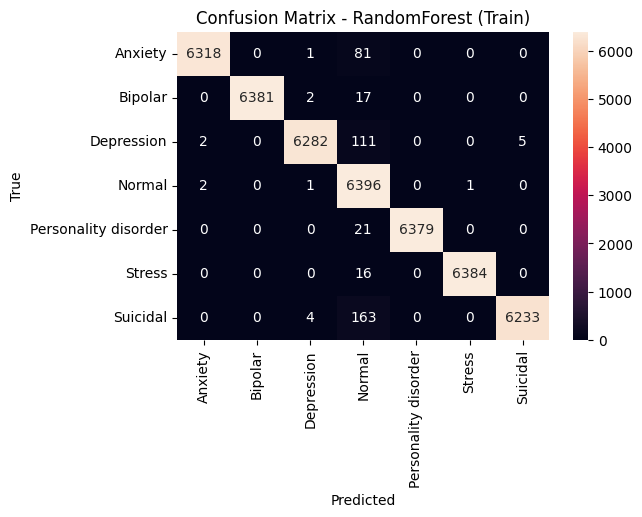


=== RandomForest Test Evaluation ===
Accuracy: 0.8222
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.89      0.86      0.87      1600
             Bipolar       0.96      0.88      0.92      1600
          Depression       0.65      0.63      0.64      1600
              Normal       0.81      0.94      0.87      1600
Personality disorder       0.91      0.94      0.93      1600
              Stress       0.86      0.83      0.85      1600
            Suicidal       0.68      0.67      0.67      1600

            accuracy                           0.82     11200
           macro avg       0.82      0.82      0.82     11200
        weighted avg       0.82      0.82      0.82     11200



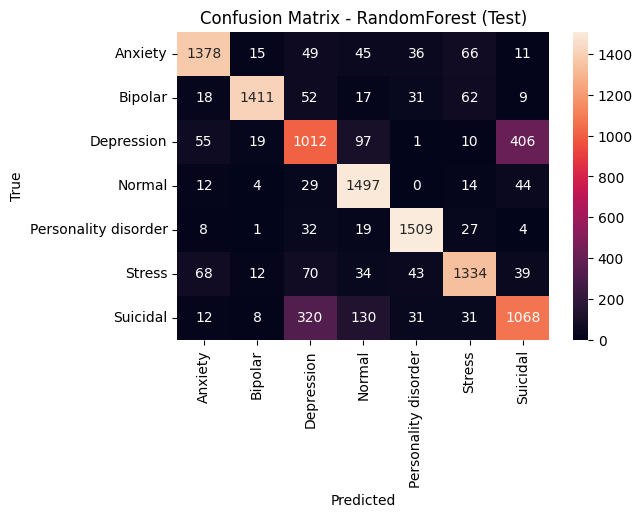

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


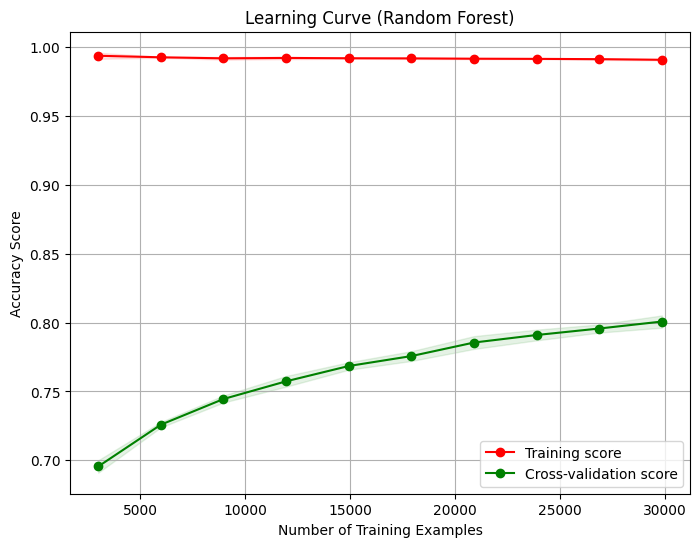

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

########################################
# Approach 2: Random Forest with Randomized Search
########################################

# Define hyperparameter distribution
param_dist = {
    'n_estimators': [200, 250, 300],
    'max_depth': [40,50,75,100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized search with return_train_score enabled
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,              # Try 10 random combinations
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Fit to training data
random_search_rf.fit(X_train_tfidf, y_train)

# Best model
best_rf = random_search_rf.best_estimator_

# Print best hyperparameters
print("=== Best Hyperparameters for RandomForest ===")
print(random_search_rf.best_params_)

# Print training and validation accuracy for each parameter combination
results = random_search_rf.cv_results_
print("\n=== Detailed CV Results ===")
for i in range(len(results['params'])):
    print("Combination {}: {}".format(i+1, results['params'][i]))
    print("Training Accuracy: {:.4f}".format(results['mean_train_score'][i]))
    print("Validation Accuracy: {:.4f}".format(results['mean_test_score'][i]))
    print("-" * 50)

# ==== Evaluate on Training Set ====
y_pred_train = best_rf.predict(X_train_tfidf)
print("\n=== RandomForest Train Evaluation ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_train, y_pred_train)))
print("Classification Report:")
print(classification_report(y_train, y_pred_train, target_names=[str(x) for x in le.classes_]))

cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6,4))
sns.heatmap(cm_train, annot=True, fmt='d',
            xticklabels=[str(x) for x in le.classes_],
            yticklabels=[str(x) for x in le.classes_])
plt.title("Confusion Matrix - RandomForest (Train)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ==== Evaluate on Test Set ====
y_pred_test = best_rf.predict(X_test_tfidf)
print("\n=== RandomForest Test Evaluation ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_test)))
print("Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=[str(x) for x in le.classes_]))

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d',
            xticklabels=[str(x) for x in le.classes_],
            yticklabels=[str(x) for x in le.classes_])
plt.title("Confusion Matrix - RandomForest (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

###############################################################################
# 4) LEARNING CURVE PLOT
###############################################################################
# We'll plot how the Random Forest's performance (training vs. cross-validation)
# evolves as we increase the size of the training set.

# Create a range of training set sizes (10 points from 10% to 100%)
train_sizes = np.linspace(0.1, 1.0, 10)

# Get learning curve data
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    best_rf,
    X_train_tfidf,
    y_train,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True
)

# Calculate mean & std of the training/cv scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='red', label='Training score')
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1, color='red'
)

plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1, color='green'
)

plt.title("Learning Curve (Random Forest)")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# **Trying XGBoost**

---




=== XGBoost Model Evaluation on Training Data ===

[XGBoost (Fixed Hyperparameters - Train)] Accuracy: 0.9207
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.93      0.94      6400
             Bipolar       0.99      0.94      0.97      6400
          Depression       0.87      0.83      0.85      6400
              Normal       0.85      0.97      0.90      6400
Personality disorder       0.98      0.98      0.98      6400
              Stress       0.95      0.93      0.94      6400
            Suicidal       0.87      0.86      0.86      6400

            accuracy                           0.92     44800
           macro avg       0.92      0.92      0.92     44800
        weighted avg       0.92      0.92      0.92     44800



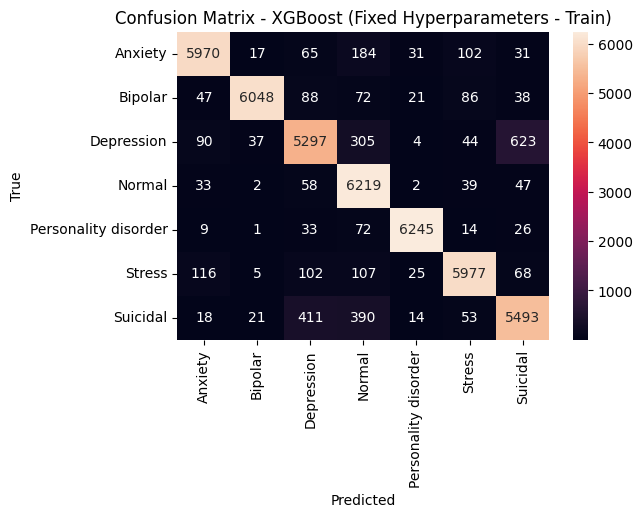


=== XGBoost Model Evaluation on Test Data ===

[XGBoost (Fixed Hyperparameters)] Accuracy: 0.8211
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.87      0.86      0.86      1600
             Bipolar       0.95      0.87      0.91      1600
          Depression       0.67      0.65      0.66      1600
              Normal       0.81      0.92      0.86      1600
Personality disorder       0.94      0.92      0.93      1600
              Stress       0.83      0.83      0.83      1600
            Suicidal       0.70      0.69      0.69      1600

            accuracy                           0.82     11200
           macro avg       0.82      0.82      0.82     11200
        weighted avg       0.82      0.82      0.82     11200



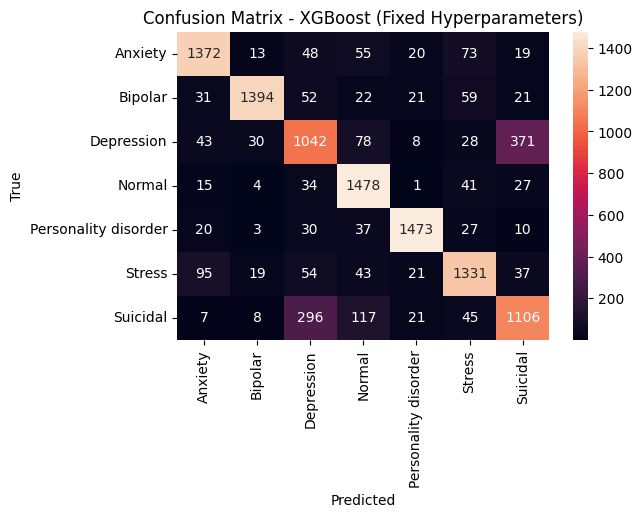

In [ ]:
import gc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

###############################################
# XGBoost with Fixed Hyperparameters
###############################################

# Fixed hyperparameters (tried with fixed parameters due to limited hardware)
fixed_params = {
    'n_estimators': 350,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

# Initialize XGBClassifier with fixed hyperparameters
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=1,
    tree_method='hist',   # Memory-efficient histogram-based algorithm
    **fixed_params
)

# Fit the model on training data
xgb_model.fit(X_train_tfidf, y_train)

# Evaluate the model on Training Data
print("\n=== XGBoost Model Evaluation on Training Data ===")
evaluate_model(xgb_model, X_train_tfidf, y_train, "XGBoost (Fixed Hyperparameters - Train)")

# Evaluate the model on Test Data
print("\n=== XGBoost Model Evaluation on Test Data ===")
evaluate_model(xgb_model, X_test_tfidf, y_test, "XGBoost (Fixed Hyperparameters)")


########################################################
#Manual testing Changing depth and number of estimaters
########################################################

#Training accuracy vs Testing accuracy -- number of estimaters, max depth
# 82.5 93  400 6
# 82 92    350 6
# 81 90    300 6
# 80 89    250 6
# 80 89    200 7
# 77 84    100 7
# 80 92    100 12
# 81 92    150 10
# 81 91    200 8
# 80 91.5  50 15
# 82 95    100 15

# **Trying XGBoost with Randomized Search**

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best Parameters Found:
{'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.05}

[Best Model] Training Accuracy: 0.9013

Training Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.94      0.92      0.93      6400
             Bipolar       0.99      0.91      0.95      6400
          Depression       0.84      0.80      0.82      6400
              Normal       0.82      0.98      0.89      6400
Personality disorder       0.98      0.95      0.97      6400
              Stress       0.93      0.92      0.92      6400
            Suicidal       0.85      0.84      0.84      6400

            accuracy                           0.90     44800
           macro avg       0.90      0.90      0.90     44800
        weighted avg       0.90      0.90      0.90     44800



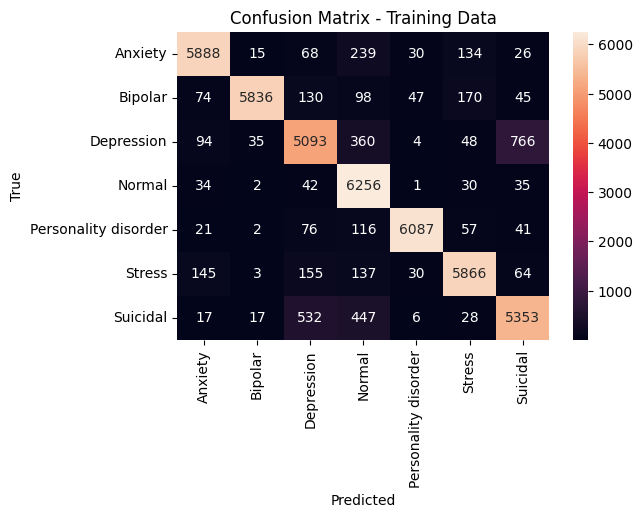


[Best Model] Test Accuracy: 0.8055

Test Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.84      0.84      1600
             Bipolar       0.95      0.85      0.90      1600
          Depression       0.65      0.65      0.65      1600
              Normal       0.78      0.92      0.85      1600
Personality disorder       0.93      0.89      0.91      1600
              Stress       0.80      0.82      0.81      1600
            Suicidal       0.69      0.67      0.68      1600

            accuracy                           0.81     11200
           macro avg       0.81      0.81      0.81     11200
        weighted avg       0.81      0.81      0.81     11200



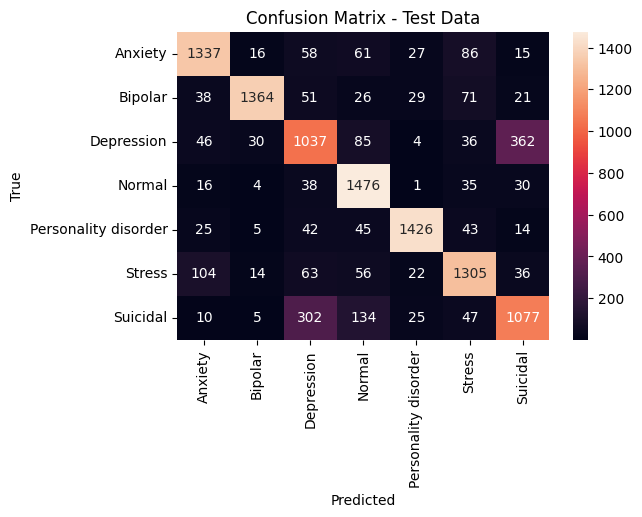

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


# Define the hyperparameter distribution for randomized search
param_distributions = {
    'n_estimators': [100, 200, 350, 400],
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=1,
    tree_method='hist'  # Using the histogram-based algorithm for efficiency
)

# Setup RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=3,           # Number of parameter settings sampled
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV on your training data (X_train_tfidf and y_train)
random_search.fit(X_train_tfidf, y_train)

print("\nBest Parameters Found:")
print(random_search.best_params_)

# Get the best model from randomized search
best_model = random_search.best_estimator_

# ---------------------------
# Evaluate on Training Data
# ---------------------------
y_train_pred = best_model.predict(X_train_tfidf)
train_acc = accuracy_score(y_train, y_train_pred)
print("\n[Best Model] Training Accuracy: {:.4f}".format(train_acc))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=class_names))

# Plot confusion matrix for Training Data
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------------------------
# Evaluate on Test Data
# ---------------------------
y_test_pred = best_model.predict(X_test_tfidf)
test_acc = accuracy_score(y_test, y_test_pred)
print("\n[Best Model] Test Accuracy: {:.4f}".format(test_acc))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Plot confusion matrix for Test Data
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# **Trying to Build a Neural Network**




In [ ]:
!pip install tensorflow


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4290 - loss: 1.4893 - val_accuracy: 0.7779 - val_loss: 0.6544
Epoch 2/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7476 - loss: 0.7372 - val_accuracy: 0.8025 - val_loss: 0.5593
Epoch 3/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7938 - loss: 0.5942 - val_accuracy: 0.8105 - val_loss: 0.5266
Epoch 4/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8224 - loss: 0.5137 - val_accuracy: 0.8127 - val_loss: 0.5081
Epoch 5/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8418 - loss: 0.4549 - val_accuracy: 0.8156 - val_loss: 0.5087
Epoch 6/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8540 - loss: 0.4149 - val_accuracy: 0.8232 - val_loss: 0.5037
Epoch 7/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8613 - loss: 0.3891 - val_accuracy: 0.8205 - val_loss: 0.5087
Epoch 8/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8731 - loss: 0.360

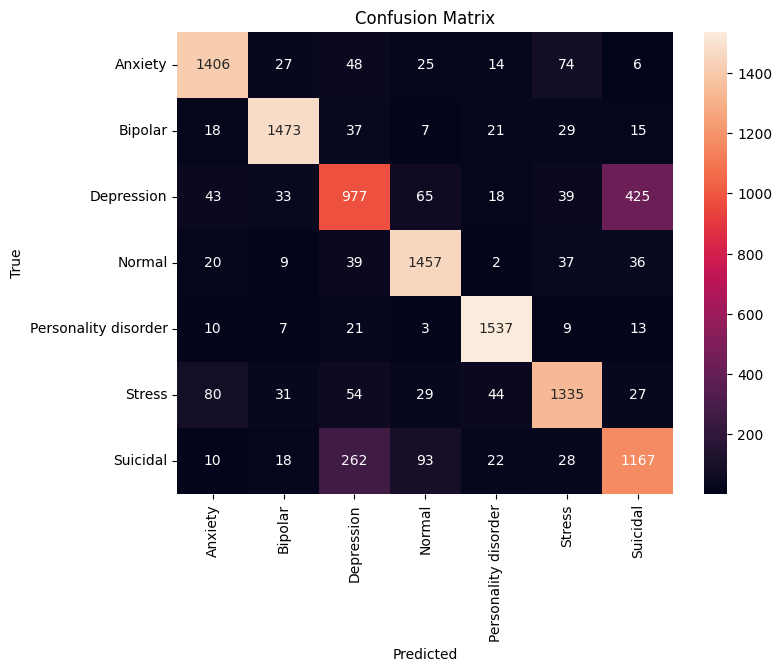

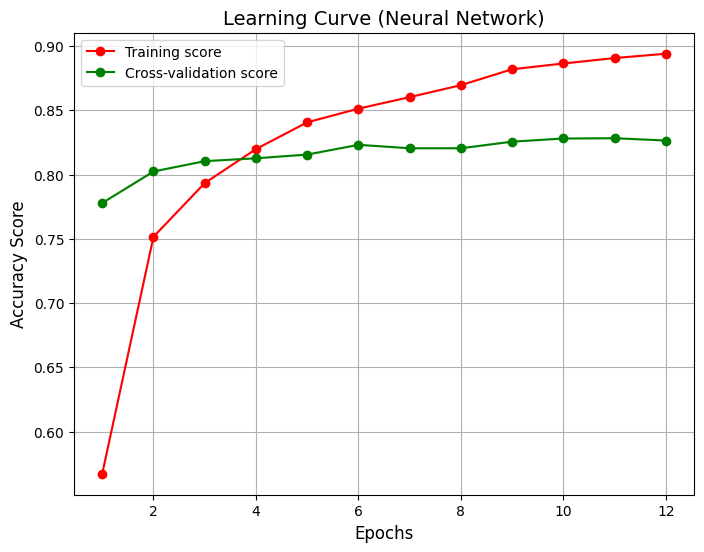

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the input dimension (number of features)
input_dim = X_train_tfidf.shape[1]

# Build the neural network model with two hidden layers
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=input_dim))
model.add(Dropout(0.5))  # Helps reduce overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
# Output layer: number of neurons equals number of classes with softmax activation for multi-class classification
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model with an appropriate optimizer and loss function for multi-class classification
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up early stopping to prevent overfitting (optional)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model (convert TF-IDF matrices to dense arrays)
history = model.fit(
    X_train_tfidf.toarray(),
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test, verbose=0)
print("Test Accuracy: {:.4f}".format(accuracy))

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf.toarray())
y_pred_labels = y_pred.argmax(axis=1)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=class_names))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Extract accuracy values
epochs = np.arange(1, len(history.history['accuracy']) + 1)
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

train_std = np.zeros_like(train_acc)
val_std = np.zeros_like(val_acc)

# Plot with custom style
plt.figure(figsize=(8, 6))
plt.title("Learning Curve (Neural Network)", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.grid(True)

# Training accuracy
plt.plot(epochs, train_acc, 'o-', color='red', label="Training score")
plt.fill_between(epochs, train_acc - train_std, train_acc + train_std, color='red', alpha=0.1)

# Validation accuracy
plt.plot(epochs, val_acc, 'o-', color='green', label="Cross-validation score")
plt.fill_between(epochs, val_acc - val_std, val_acc + val_std, color='green', alpha=0.1)

plt.legend(loc="best")
plt.show()
